<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#adding-deeper-strategic-elements-to-auto-trading-strategy" data-toc-modified-id="adding-deeper-strategic-elements-to-auto-trading-strategy-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>adding deeper strategic elements to auto-trading strategy</a></span><ul class="toc-item"><li><span><a href="#or,-&quot;nuance&quot;" data-toc-modified-id="or,-&quot;nuance&quot;-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>or, "nuance"</a></span></li></ul></li><li><span><a href="#areas-to-improve" data-toc-modified-id="areas-to-improve-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>areas to improve</a></span><ul class="toc-item"><li><span><a href="#threshold-gradients" data-toc-modified-id="threshold-gradients-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>threshold gradients</a></span></li><li><span><a href="#rolling-volatility" data-toc-modified-id="rolling-volatility-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>rolling volatility</a></span></li><li><span><a href="#multiple-active-PPAs" data-toc-modified-id="multiple-active-PPAs-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>multiple active PPAs</a></span></li><li><span><a href="#drawdown" data-toc-modified-id="drawdown-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>drawdown</a></span></li><li><span><a href="#maximum-drawdown" data-toc-modified-id="maximum-drawdown-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>maximum drawdown</a></span></li></ul></li><li><span><a href="#rolling_max()" data-toc-modified-id="rolling_max()-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>rolling_max()</a></span><ul class="toc-item"><li><span><a href="#MDD:" data-toc-modified-id="MDD:-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>MDD:</a></span></li></ul></li></ul></div>

# adding deeper strategic elements to auto-trading strategy
## or, "nuance"
The initial test got 9% 90-day returns, but didn't account for real-world pitfalls, such as trade orders not being filled due to excessive demand or exchange fees.

CoinbasePro fees are quite small (around 0.5%), and they'll be easy to simulate in the buy/sell methods. Order shortages are more complex - we could add a module that gives every trade an X% chance to "fail", or purchase "late". Could calculate X based on... what? volatility? since volatility is an indicator of trading volume over time (frequency).

I'll spend a deal of time overhauling the core logic, of course. The bot currently works on "Bet 10% of whole portfolio on every PPA with an initial move & partnered auto-shop single threshold".

# areas to improve

## threshold gradients
- right now, if we buy from a PPA's trigger and the 75% auto-stop threshold is a \$40 price increase, the price could rise by \$39, then dip back down, and the stop will never trigger a sell.
    - so we're certainly missing out on some profit.
- investigation:
    - for each auto-stop object, we could record the max/min price change (towards the 75% threshold). collect all stops at the end of function
        - then we compare "how close did the actual price get to the 75% threshold"? both in absolute and pct%
- this could tell us if we want to do gradient stop-selling
- although this sort of goes counter to the whole "we're betting on the 75% chance" thing. if the price reaches \$35 on that specific PPA, do we run an... 80% chance of selling? or do we wait and bet for the 75%?
    - this is risk balancing (like everything else), of course, but perhaps there's better areas to optimize for the time being
    

## rolling volatility
- we could keep a rolling track of how volatile the market price is at every 5-minute interval
    - based on X rows back in time
    - why is __volatility__ good for this analysis?
        - if more people are buying/selling, the price is more likely to change (i'm fairly certain that's how this works)
        - so if the PPA says "i think it's gonna change in this direction over _T_ time"
            - volatility gives us more insight into how it might change and when
- if price is \$3500 and we get a 7.5hr long with 75\% rise to \$3600, we could ask ourselves "how likely is it to hit the target _this time_? how likely is it to go beyond?"
    - volatility can inform this, i think.
            

## multiple active PPAs
- if a 15 hour long triggers with 75% = \$100 & current_price= \$3500, we buy with 10% current_USD, and set an autostop to sell 10% of current_BTC if price exceeds \$3600 increase at any point in the next 15 hours
    - but what if a 75-minute short triggers 1 hour into this 15-hour period, when current_price=\$3200, predicting 75% = \$-30?
        - then we'll sell 10% of our BTC for \$300 lower price, incurring loss
        - and set auto-stop to buy with 10% of USD if price hits \$3260 in the next 75 minutes
            - it's a double gamble, but if the second pulls through we recoup the loss from not "following through with only the first"
            - and since we've made money on the second (and bought/sold 10%) we're still on track to hold/wait for the original 15-hour long to sell at \$3600
- i'm not really sure what to do with this one yet. perhaps loop through data and count occurences of "nested PPAs", keeping note of type, duration and how much they "conflict"
    - bill writes that in these situations, standard technical indicators may indicate that the chart is moving strongly in one of the two (outer or inner nested PPA) directions, so we could ignore the inner counter-PPA or use it only as stop-loss target

## drawdown
- extent to which investment is below its highest net value
    - peak-to-trough / peak-to-valley DD == amount of loss incurred since previous peak
- evaluates how long it usually takes an investment to recover from temp decline in value
    - measures "downside risk"
        - recovery period / 'time under water' = time that investment needs to reach height of previous peak
        - shorter recovery periods are ofc better
- formula:
    - DDt = minimum of 0 or G
    - G = (current_portfolio_val - historical_peak) / (historical_peak)
- average DD is more informative 
- but max is even better

## maximum drawdown
- MDDt = max(DDt)
- measures largest percentage loss an investor could have experienced on investment
    - MDD measures "worst case scenario" of investor who invested at peak and held during the fall, losing loadsamoney
- i'm not quire sure what bill means by "margin = one BTC for each new portfolio launched"
    - oh, i think... perhaps he's referring to the fact that i'm running 90 distinct portfolios concurrently rolling, rather than trading 90 accounts as part of the same portfolio
    - that's where the idea of "margins" comes into play, with leverage ratios and such
    - you can trade with more or less of the 90 accounts in the portfolio based on how much risk you want to take
        - ... i think?
- bill on capital account size:
    - capital account size = (margin required + safety factor * MDD).
    - since i didn't bother with MDDs, i can't set capital account size
        - if we have single run with 1BTC capital, if accumualated equity position is a loss greater than one BTC during the 90 days, then account is bankrupt mid-life, never generating returns
            - MDD must be known
            - MDD must be calculated 2 ways
                - 1) at trade close to trade close
                - 2) at intraday peak to valley (worse-case modeling)
        - MDD is complicated in a rolling strategy: there are 90 portfolios simultaneously acting; their drawdowns have to be calculated and combined at each bar to calculate the overall strategy MDD
    - bill likes a 2x safety factor on the MDD
    
    
 

# rolling_max()
thank you pandas

In [ ]:
import pandas as pd
from pandas_datareader import data as web
# import pandas.io.data as web
import matplotlib.pyplot as pp
import datetime

# Get SPY data for past several years
SPY_Dat = web.DataReader('SPY', 'yahoo', datetime.date(2007,1,1))

# We are going to use a trailing 252 trading day window
# i assume this data is daily
window = 252

# Calculate the max drawdown in the past window days for each day in the series.
# Use min_periods=1 if you want to let the first 252 days data have an expanding window
# Roll_Max = pd.rolling_max(SPY_Dat['Adj Close'], window, min_periods=1)
Roll_Max = SPY_Dat['Adj Close'].rolling(window, min_periods=1).max() # have to rewrite rolling functions
Daily_Drawdown = SPY_Dat['Adj Close']/Roll_Max - 1.0

# Next we calculate the minimum (negative) daily drawdown in that window.
# Again, use min_periods=1 if you want to allow the expanding window
# Max_Daily_Drawdown = pd.rolling_min(Daily_Drawdown, window, min_periods=1)
Max_Daily_Drawdown = Daily_Drawdown.rolling(window, min_periods=1).min()

In [11]:
Daily_Drawdown

Date
2007-01-03    0.000000
2007-01-04    0.000000
2007-01-05   -0.007976
2007-01-08   -0.003388
2007-01-09   -0.004235
                ...   
2020-09-30   -0.060021
2020-10-01   -0.053986
2020-10-02   -0.062968
2020-10-05   -0.046352
2020-10-06   -0.056484
Name: Adj Close, Length: 3465, dtype: float64

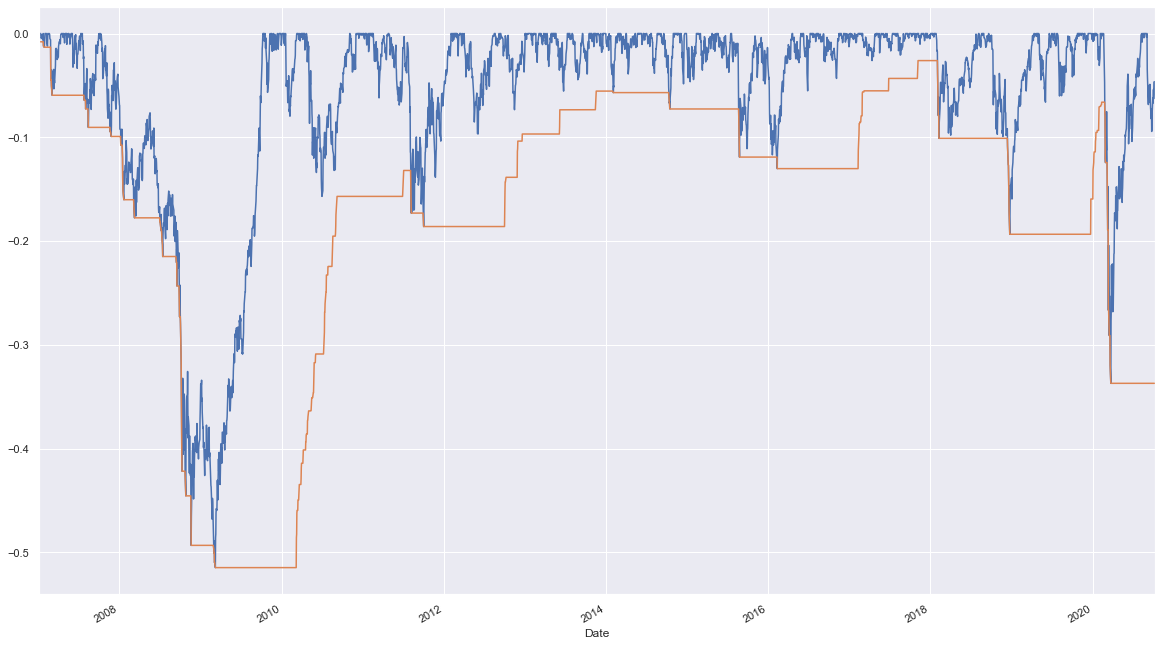

In [9]:
# Plot the results
import seaborn as sns
sns.set(rc={'figure.figsize':(20, 12)})
Daily_Drawdown.plot()
Max_Daily_Drawdown.plot()
pp.show()

## MDD:
so I know how to calculate a rolling max_drawdown. how do we use it, though?

this isn't a ML problem so much as a coding and financial knowledge translation problem. implementing daily drawdowns would help a lot with portfolio stability, but we're running one account in each portfolio without any safety factors. i should start by researching acceptable safety ranges for common investors and calculating from there